# Heart Failure Prediction

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import fnmatch
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from pprint import pprint

## Load data and take a first look

In [2]:
# get path of the input file
cwd = os.getcwd()
input_path = os.path.join(cwd, "input")
lst_input_files = [file for file in listdir(input_path) if fnmatch.fnmatch(file, '*.csv')]
input_file = os.path.join(input_path, lst_input_files[0])

In [3]:
df = pd.read_csv(input_file)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [4]:
df.describe()
# creatinine_phosphokinase: max value is larger than the mean or even the 75 percentile by a big margin --> outlier? minmax scaler would not work well

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


In [5]:
# no null values
above_0_missing = df.isnull().sum() > 0
df.isnull().sum()[above_0_missing]

Series([], dtype: int64)

In [6]:
from sklearn.model_selection import train_test_split

# split the data into train and test set
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

array([[<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'anaemia'}>,
        <AxesSubplot:title={'center':'creatinine_phosphokinase'}>,
        <AxesSubplot:title={'center':'diabetes'}>],
       [<AxesSubplot:title={'center':'ejection_fraction'}>,
        <AxesSubplot:title={'center':'high_blood_pressure'}>,
        <AxesSubplot:title={'center':'platelets'}>,
        <AxesSubplot:title={'center':'serum_creatinine'}>],
       [<AxesSubplot:title={'center':'serum_sodium'}>,
        <AxesSubplot:title={'center':'sex'}>,
        <AxesSubplot:title={'center':'smoking'}>,
        <AxesSubplot:title={'center':'time'}>],
       [<AxesSubplot:title={'center':'DEATH_EVENT'}>, <AxesSubplot:>,
        <AxesSubplot:>, <AxesSubplot:>]], dtype=object)

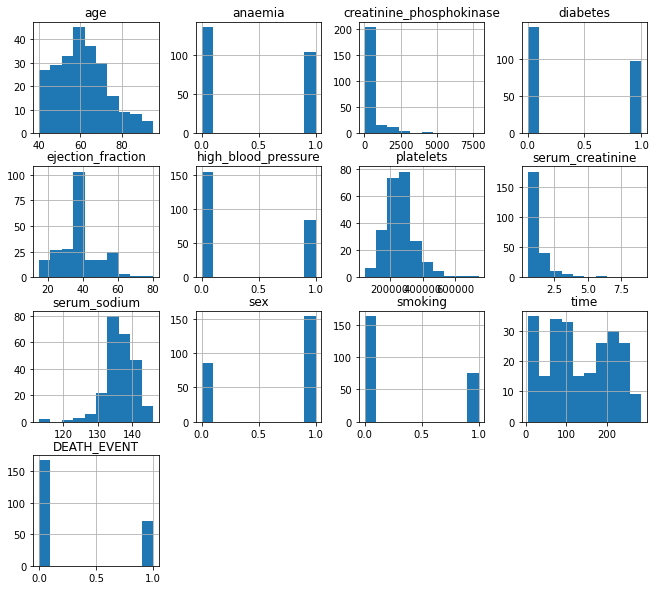

In [7]:
train_data.hist(figsize=(11, 10))

In [8]:
# all cat attributes are boolean values
cat_atts = ["anaemia", "diabetes", "high_blood_pressure", "sex", "smoking"]
num_atts = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
class_atts = ['age_class', 'creatinine_phosphokinase_class', 'ejection_fraction_class', 'platelets_class',
              'serum_creatinine_class', 'serum_sodium_class', 'time_class']

In [9]:
for cat in cat_atts:
    print(df[cat].value_counts())

0    170
1    129
Name: anaemia, dtype: int64
0    174
1    125
Name: diabetes, dtype: int64
0    194
1    105
Name: high_blood_pressure, dtype: int64
1    194
0    105
Name: sex, dtype: int64
0    203
1     96
Name: smoking, dtype: int64


<AxesSubplot:>

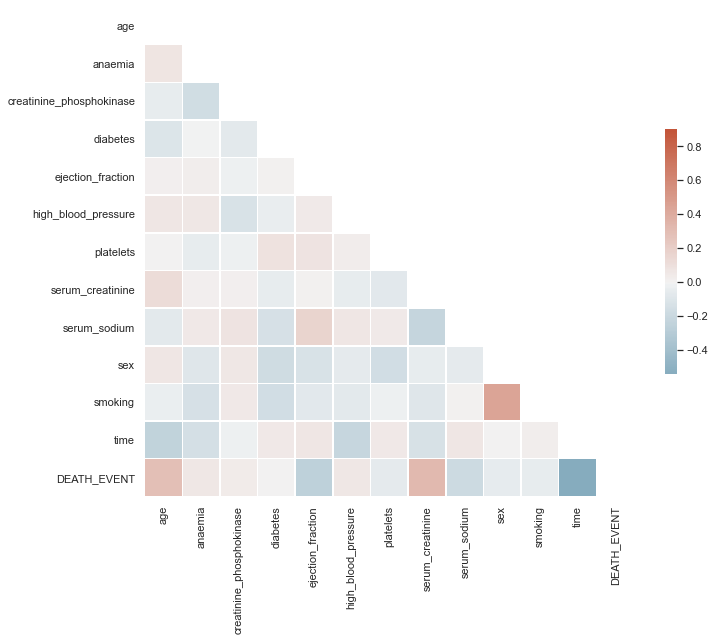

In [10]:
corr_mat = train_data.corr()

# Plotting diagonal correlation matrix

sns.set_theme(style="white")

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_mat, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_mat, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [11]:
corr_mat["DEATH_EVENT"].sort_values(ascending=False)

DEATH_EVENT                 1.000000
serum_creatinine            0.326517
age                         0.289363
high_blood_pressure         0.058417
anaemia                     0.057337
creatinine_phosphokinase    0.035271
diabetes                    0.003433
smoking                    -0.044995
sex                        -0.052579
platelets                  -0.058639
serum_sodium               -0.189510
ejection_fraction          -0.257293
time                       -0.539406
Name: DEATH_EVENT, dtype: float64

array([[<AxesSubplot:xlabel='age', ylabel='age'>,
        <AxesSubplot:xlabel='creatinine_phosphokinase', ylabel='age'>,
        <AxesSubplot:xlabel='ejection_fraction', ylabel='age'>,
        <AxesSubplot:xlabel='platelets', ylabel='age'>,
        <AxesSubplot:xlabel='serum_creatinine', ylabel='age'>,
        <AxesSubplot:xlabel='serum_sodium', ylabel='age'>,
        <AxesSubplot:xlabel='time', ylabel='age'>],
       [<AxesSubplot:xlabel='age', ylabel='creatinine_phosphokinase'>,
        <AxesSubplot:xlabel='creatinine_phosphokinase', ylabel='creatinine_phosphokinase'>,
        <AxesSubplot:xlabel='ejection_fraction', ylabel='creatinine_phosphokinase'>,
        <AxesSubplot:xlabel='platelets', ylabel='creatinine_phosphokinase'>,
        <AxesSubplot:xlabel='serum_creatinine', ylabel='creatinine_phosphokinase'>,
        <AxesSubplot:xlabel='serum_sodium', ylabel='creatinine_phosphokinase'>,
        <AxesSubplot:xlabel='time', ylabel='creatinine_phosphokinase'>],
       [<AxesSubplot:xl

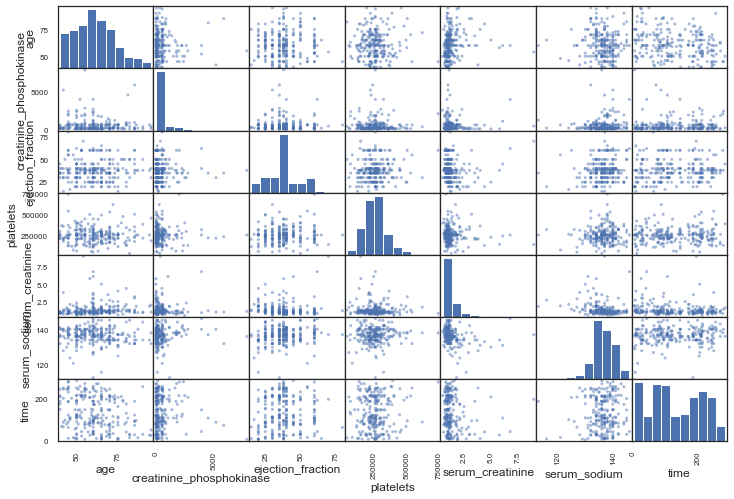

In [12]:
from pandas.plotting import scatter_matrix

scatter_matrix(train_data[num_atts], figsize=(12, 8))

In [13]:
train_data.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000,239.000000
mean,61.059975,0.435146,577.083682,0.405858,38.263598,0.351464,262427.450209,1.387364,136.418410,0.644351,0.313808,132.297071,0.297071
std,11.999013,0.496817,946.937475,0.492088,11.651161,0.478430,94272.495618,0.994975,4.440152,0.479714,0.465013,78.350857,0.457927
min,40.000000,0.000000,23.000000,0.000000,15.000000,0.000000,47000.000000,0.500000,113.000000,0.000000,0.000000,4.000000,0.000000
25%,52.000000,0.000000,111.500000,0.000000,30.000000,0.000000,212500.000000,0.900000,134.000000,0.000000,0.000000,73.500000,0.000000
50%,60.000000,0.000000,245.000000,0.000000,38.000000,0.000000,263000.000000,1.100000,137.000000,1.000000,0.000000,119.000000,0.000000
75%,69.500000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.400000,139.000000,1.000000,1.000000,205.500000,1.000000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,742000.000000,9.000000,146.000000,1.000000,1.000000,285.000000,1.000000


### Data investigation

In [14]:
def quantile_values(df, att):
    quantiles = [.25, .5, .75]
    value_quantiles = [df[att].quantile(q) for q in quantiles]
    bins = [0.0] + value_quantiles + [np.inf]
    labels = [f"{att}_low", f"{att}_middle", f"{att}_high", f"{att}_very_high"]
    new_att_name = f"{att}_class"
    return bins, labels, new_att_name

def quantile_class_report(df_og, att):
    df = df_og.copy()
    bins, labels, new_att_name = quantile_values(df, att)
    df[new_att_name] = pd.cut(df[att],
                         bins=bins,
                         labels=labels)
    tot_deaths = df["DEATH_EVENT"].sum()
    tot_sample_size = df.shape[0]
    grouped_age = df[[new_att_name, "DEATH_EVENT"]].groupby([new_att_name]).agg(["sum", "count"])
    grouped_age.columns = grouped_age.columns.droplevel()
    grouped_age["share_death"] = round(grouped_age["sum"] / tot_deaths, 3)
    grouped_age["share_sample"] = round(grouped_age["count"] / tot_sample_size, 3)
    grouped_age["mortality_rate"] = round(grouped_age["sum"] / grouped_age["count"], 3)
    grouped_age.rename(columns={"sum": "deaths", "count": "sample_size"}, inplace=True)
    return grouped_age

def get_all_reports(df, lst_att):
    group_dict = {}
    for att in lst_att:
        group_dict[att] = quantile_class_report(df, att)
    return group_dict

In [15]:
lst_att = ["age", "creatinine_phosphokinase", "ejection_fraction", "platelets", "serum_creatinine", "serum_sodium", "time"]
group_dict = get_all_reports(train_data, lst_att)

In [16]:
# Significant higher mortality rate for very old people
# Significant lower mortaility rate for young people
group_dict["age"]

,deaths,sample_size,share_death,share_sample,mortality_rate
age_class,,,,,
age_low,11,64,0.155,0.268,0.172
age_middle,18,64,0.254,0.268,0.281
age_high,14,51,0.197,0.213,0.275
age_very_high,28,60,0.394,0.251,0.467


In [17]:
# Slightly higher mortality rate for people between middle and high level of ejection_fraction
group_dict["creatinine_phosphokinase"]

,deaths,sample_size,share_death,share_sample,mortality_rate
creatinine_phosphokinase_class,,,,,
creatinine_phosphokinase_low,14,60,0.197,0.251,0.233
creatinine_phosphokinase_middle,21,60,0.296,0.251,0.350
creatinine_phosphokinase_high,24,68,0.338,0.285,0.353
creatinine_phosphokinase_very_high,12,51,0.169,0.213,0.235


In [18]:
# Significant higher mortality rate for people with low level of ejection_fraction
# Significant lower mortaility rate forpeople with high level of ejection_fraction
group_dict["ejection_fraction"]

,deaths,sample_size,share_death,share_sample,mortality_rate
ejection_fraction_class,,,,,
ejection_fraction_low,37,72,0.521,0.301,0.514
ejection_fraction_middle,17,71,0.239,0.297,0.239
ejection_fraction_high,6,49,0.085,0.205,0.122
ejection_fraction_very_high,11,47,0.155,0.197,0.234


In [19]:
# Similiar mortality rate across all levels
group_dict["platelets"]

,deaths,sample_size,share_death,share_sample,mortality_rate
platelets_class,,,,,
platelets_low,21,60,0.296,0.251,0.350
platelets_middle,15,60,0.211,0.251,0.250
platelets_high,17,59,0.239,0.247,0.288
platelets_very_high,18,60,0.254,0.251,0.300


In [20]:
# Extremely high mortality rate for people with low level of serum_creatinine
# Extremely low mortaility rate for people with low level of serum_creatinine
group_dict["serum_creatinine"]

,deaths,sample_size,share_death,share_sample,mortality_rate
serum_creatinine_class,,,,,
serum_creatinine_low,5,65,0.070,0.272,0.077
serum_creatinine_middle,18,67,0.254,0.280,0.269
serum_creatinine_high,14,52,0.197,0.218,0.269
serum_creatinine_very_high,34,55,0.479,0.230,0.618


In [21]:
# Slightly higher mortality rate for people with low level of serum_sodium
group_dict["serum_sodium"]

,deaths,sample_size,share_death,share_sample,mortality_rate
serum_sodium_class,,,,,
serum_sodium_low,32,70,0.451,0.293,0.457
serum_sodium_middle,18,74,0.254,0.310,0.243
serum_sodium_high,7,36,0.099,0.151,0.194
serum_sodium_very_high,14,59,0.197,0.247,0.237


In [22]:
# Extremely high mortality rate for people with short follow-up period
# Extremely low mortaility rate for people with long follow-up period
group_dict["time"]

,deaths,sample_size,share_death,share_sample,mortality_rate
time_class,,,,,
time_low,50,60,0.704,0.251,0.833
time_middle,7,60,0.099,0.251,0.117
time_high,10,59,0.141,0.247,0.169
time_very_high,4,60,0.056,0.251,0.067


## Under- and oversampling

0    168
1     71
Name: DEATH_EVENT, dtype: int64

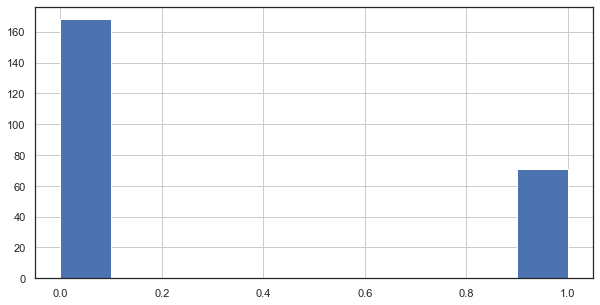

In [23]:
# check for distribution of the labels in the training data
train_data["DEATH_EVENT"].hist(figsize=(10,5))
train_data["DEATH_EVENT"].value_counts()
# the positive class is underepresented --> use over- and undersampling to adjust the distribution

In [24]:
# split data into data values and labels
X_train = train_data.drop("DEATH_EVENT", axis=1)
y_train = train_data["DEATH_EVENT"].copy()

X_test = test_data.drop("DEATH_EVENT", axis=1)
y_test = test_data["DEATH_EVENT"].copy()

In [25]:
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# define pipeline
over = RandomOverSampler(sampling_strategy=0.6)
under = RandomUnderSampler(sampling_strategy=0.7)

steps = [('o', over), ('u', under)]
balance_pipeline = imblearn.pipeline.Pipeline(steps=steps)
X_train_bal, y_train_bal = balance_pipeline.fit_resample(X_train, y_train)
print("Original y distribution:", Counter(y_train))
print("Balanced y distribution:", Counter(y_train_bal))

Original y distribution: Counter({0: 168, 1: 71})
Balanced y distribution: Counter({0: 142, 1: 100})


In [26]:
X_train_bal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       242 non-null    float64
 1   anaemia                   242 non-null    int64  
 2   creatinine_phosphokinase  242 non-null    int64  
 3   diabetes                  242 non-null    int64  
 4   ejection_fraction         242 non-null    int64  
 5   high_blood_pressure       242 non-null    int64  
 6   platelets                 242 non-null    float64
 7   serum_creatinine          242 non-null    float64
 8   serum_sodium              242 non-null    int64  
 9   sex                       242 non-null    int64  
 10  smoking                   242 non-null    int64  
 11  time                      242 non-null    int64  
dtypes: float64(3), int64(9)
memory usage: 22.8 KB


# Preprocessing

In [27]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

X = X_train_bal.copy()

prep_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_atts),
    ("cat", "passthrough", cat_atts)
])

X_train_prep = prep_pipeline.fit_transform(X)

## Model Checking

In [28]:
import re
from operator import itemgetter

def display_scores(clf_name, scores, lst_metric_names):
    lst_test = [key for key in scores.keys() if "test" in key]
    lst_train = [key for key in scores.keys() if "train" in key]
    print(f"Model: {clf_name}") 
    for train_key, test_key in zip(lst_train, lst_test):
        pattern = re.compile(r'\w+_(\w+)')
        matches = pattern.finditer(train_key)
        for match in matches:
            scoring_method = match.group(1)   
        print(f"   Scoring method: {scoring_method}")
        print(f"   Mean: train={scores[train_key].mean()} / test={scores[test_key].mean()}")
        print(f"   Standard deviation: train={scores[train_key].std()} / test={scores[test_key].std()} \n")
        

# display the model with the highest test score for the specified metric
def display_top_3(lst_scores, metric):
    lst_mean_score = []
    for tup in lst_scores:
        clf_name = tup[0]
        mean_train_score = tup[1]["train_" + metric].mean()
        mean_test_score = tup[1]["test_" + metric].mean()
        std_train = tup[1]["train_" + metric].std()
        std_test = tup[1]["test_" + metric].std()
        lst_mean_score.append((clf_name, mean_train_score, mean_test_score, std_train, std_test))
    lst_sorted = sorted(lst_mean_score, key=itemgetter(2), reverse=True)
    for tup in lst_sorted[:3]:
        print(f"Model: {tup[0]}") 
        print(f"   Scoring method: {metric}")
        print(f"   Mean: train={tup[1]} / test={tup[2]}")
        print(f"   Standard deviation: train={tup[3]} / test={tup[4]} \n")

In [29]:
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_validate, RepeatedStratifiedKFold


log_clf = LogisticRegression(random_state=42)
tree_clf = DecisionTreeClassifier(random_state=42, max_depth=4)
svm_clf = SVC(random_state=42)
knn_clf = KNeighborsClassifier()
sgd_clf = SGDClassifier(random_state=42)


lst_clf = [("Logistic", log_clf), ("Decision Tree", tree_clf), ("SVM", svm_clf),
           ("KNN", knn_clf), ("SGD", sgd_clf)]

scoring = {"accuracy": "accuracy",
           "precision": "precision",
           "recall": "recall"}

lst_scores = []

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)

for name, clf in lst_clf:
    scores = cross_validate(clf, X_train_prep, y_train_bal, scoring=scoring, cv=cv, return_train_score=True)
    display_scores(name, scores, list(scoring.keys()))
    lst_scores.append((name, scores))

Model: Logistic
   Scoring method: accuracy
   Mean: train=0.8314977663157597 / test=0.7959999999999999
   Standard deviation: train=0.012131835120671838 / test=0.07655499112838213 

   Scoring method: precision
   Mean: train=0.8022674536640196 / test=0.7700703925703926
   Standard deviation: train=0.012498508864741778 / test=0.10628396999012217 

   Scoring method: recall
   Mean: train=0.7859259259259258 / test=0.7366666666666666
   Standard deviation: train=0.024999314119535116 / test=0.17220788470785986 

Model: Decision Tree
   Scoring method: accuracy
   Mean: train=0.9245451598810581 / test=0.800111111111111
   Standard deviation: train=0.012320439703458683 / test=0.06589966185117162 

   Scoring method: precision
   Mean: train=0.9223479894808918 / test=0.773553946053946
   Standard deviation: train=0.040866631937026644 / test=0.11150854909831989 

   Scoring method: recall
   Mean: train=0.8966666666666666 / test=0.7599999999999999
   Standard deviation: train=0.0490359740289

In [30]:
# for this use case we want to prioritze accuracy
metric = "accuracy"
display_top_3(lst_scores, metric)

# Performance
# 1st SVM
# 2nd Decision Tree
# 3rd Logistic

Model: SVM
   Scoring method: accuracy
   Mean: train=0.9175129300018321 / test=0.848388888888889
   Standard deviation: train=0.008945055532020631 / test=0.0750598321012093 

Model: Decision Tree
   Scoring method: accuracy
   Mean: train=0.9245451598810581 / test=0.800111111111111
   Standard deviation: train=0.012320439703458683 / test=0.06589966185117162 

Model: Logistic
   Scoring method: accuracy
   Mean: train=0.8314977663157597 / test=0.7959999999999999
   Standard deviation: train=0.012131835120671838 / test=0.07655499112838213 



## Ensemble Learning

In [64]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier

# apply some regularization, since the performance on the train score is much higher 
# than the test score to prevent too much overfitting
rnd_clf = RandomForestClassifier(random_state=42, max_depth=4, n_estimators=10)
extr_clf = ExtraTreesClassifier(random_state=42, max_depth=4, n_estimators=10)
log_bag_clf = BaggingClassifier(LogisticRegression(random_state=42), random_state=42, n_estimators=10)
svm_bag_clf = BaggingClassifier(SVC(random_state=42), random_state=42, n_estimators=10)
svm_ada_clf = AdaBoostClassifier(SVC(random_state=42, probability=True), random_state=42,
                                 n_estimators=10, algorithm="SAMME.R", learning_rate=0.001)
tree_ada_clf = AdaBoostClassifier(DecisionTreeClassifier(random_state=42, max_depth=4),
                                  random_state=42, n_estimators=10, algorithm="SAMME.R", learning_rate=0.001)
grad_clf = GradientBoostingClassifier(random_state=42, learning_rate=1.7, max_depth=2, n_estimators=10)


lst_ens_clf = [("Random Forest", rnd_clf), ("Extra Trees", extr_clf), ("Logistic Bagging", log_bag_clf),
               ("SVM Bagging", svm_bag_clf), ("Tree AdaBoost", tree_ada_clf),
               ("SVM AdaBoost", svm_ada_clf), ("GradientBoosting", grad_clf)]

lst_ens_scores = []

for name, clf in lst_ens_clf:
    ens_scores = cross_validate(clf, X_train_prep, y_train_bal, scoring=scoring, cv=cv, return_train_score=True)
    display_scores(name, ens_scores, list(scoring.keys()))
    lst_ens_scores.append((name, ens_scores))

Model: Random Forest
   Scoring method: accuracy
   Mean: train=0.9297404134782058 / test=0.8593333333333334
   Standard deviation: train=0.01584494168623263 / test=0.05952061578733628 

   Scoring method: precision
   Mean: train=0.9469836574067971 / test=0.8695081770081771
   Standard deviation: train=0.017768218519167985 / test=0.08765460651707094 

   Scoring method: recall
   Mean: train=0.8796296296296295 / test=0.7899999999999999
   Standard deviation: train=0.037743266734789185 / test=0.1374772708486752 

Model: Extra Trees
   Scoring method: accuracy
   Mean: train=0.8276659761270593 / test=0.7810555555555554
   Standard deviation: train=0.012244744832691053 / test=0.06619623371480202 

   Scoring method: precision
   Mean: train=0.9651707311517211 / test=0.9155687830687831
   Standard deviation: train=0.012120515197065668 / test=0.12050186215834459 

   Scoring method: recall
   Mean: train=0.6048148148148147 / test=0.5233333333333333
   Standard deviation: train=0.0279157069

In [65]:
metric = "accuracy"
display_top_3(lst_ens_scores, metric)
# 1st Random Forest--> Choose it for finetuning

Model: Random Forest
   Scoring method: accuracy
   Mean: train=0.9297404134782058 / test=0.8593333333333334
   Standard deviation: train=0.01584494168623263 / test=0.05952061578733628 

Model: SVM Bagging
   Scoring method: accuracy
   Mean: train=0.9118448681633055 / test=0.837388888888889
   Standard deviation: train=0.013112161457457725 / test=0.0685318030164927 

Model: GradientBoosting
   Scoring method: accuracy
   Mean: train=0.9251469158246312 / test=0.8209444444444444
   Standard deviation: train=0.06594354925057114 / test=0.08039219067165453 



## Feature Selection & Engineering

In [43]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from operator import itemgetter

class ClassAdder(BaseEstimator, TransformerMixin):
    def __init__(self, sel_atts):
        self.sel_atts = sel_atts
    def fit(self, X, y=None):
        return self
    def transform(self, X): 
        for att in self.sel_atts:
            bins, labels, new_att_name = quantile_values(X, att)
            X[new_att_name] = pd.cut(X[att],
                                    bins=bins,
                                    labels=labels)
        X.drop(num_atts, axis=1, inplace=True)
        return X
    
class Selector(BaseEstimator, TransformerMixin):
    def __init__(self, sel_atts):
        self.sel_atts = sel_atts
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.sel_atts]

In [44]:
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean test score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_test_score'][candidate],
                          results['std_test_score'][candidate]))
            print("Mean train score: {0:.3f} (std: {1:.3f})"
                  .format(results['mean_train_score'][candidate],
                          results['std_train_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [66]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from itertools import combinations
from time import time

# compare performance of 
# 1. converting all num to cat atts and drop the num atts
# 2. converting all num to cat atts and keep the num atts
# 3. keep the num atts as it is

X = X_train_bal.copy()
rnd_clf = RandomForestClassifier(random_state=42, max_depth=4, n_estimators=10)

all_comb = []

# get all combinations of features for each length
for i in range(1, len(num_atts)+1):
    all_comb.extend([list(t) for t in list(combinations(num_atts, i))])
    
param_grid = {
    "preparation__adder__class__sel_atts": all_comb,
    "preparation__num__select__sel_atts": all_comb,
}

class_pipeline = Pipeline([
    ("class", ClassAdder(num_atts)),
    ("enc", OneHotEncoder())
])

num_pipeline = Pipeline([
    ("select", Selector(num_atts)),
    ("std", StandardScaler())
])

prep_pipeline = ColumnTransformer([
    ("adder", class_pipeline, num_atts),
    ("num", num_pipeline, num_atts),
    ("cat", "passthrough", cat_atts)
])

full_pipeline_class = Pipeline([
    ('preparation', prep_pipeline),
    ('rnd_clf', rnd_clf)
])

grid_search_prep = GridSearchCV(full_pipeline_class, param_grid, cv=cv,
                                scoring='accuracy', verbose=1, n_jobs=-1, return_train_score=True)

# start time of running grid_search_prep
start = time()
grid_search_prep.fit(X, y_train_bal)

print("GridSearchCV took %.2f seconds." % ((time() - start)))
report(grid_search_prep.cv_results_)

Fitting 5 folds for each of 16129 candidates, totalling 80645 fits
GridSearchCV took 1848.31 seconds.
Model with rank: 1
Mean test score: 0.897 (std: 0.029)
Mean train score: 0.920 (std: 0.013)
Parameters: {'preparation__adder__class__sel_atts': ['creatinine_phosphokinase', 'platelets', 'time'], 'preparation__num__select__sel_atts': ['ejection_fraction', 'platelets', 'serum_creatinine', 'time']}

Model with rank: 2
Mean test score: 0.893 (std: 0.021)
Mean train score: 0.931 (std: 0.019)
Parameters: {'preparation__adder__class__sel_atts': ['age', 'ejection_fraction', 'time'], 'preparation__num__select__sel_atts': ['creatinine_phosphokinase', 'ejection_fraction', 'serum_creatinine', 'serum_sodium', 'time']}

Model with rank: 3
Mean test score: 0.892 (std: 0.046)
Mean train score: 0.908 (std: 0.019)
Parameters: {'preparation__adder__class__sel_atts': ['serum_creatinine', 'time'], 'preparation__num__select__sel_atts': ['creatinine_phosphokinase', 'ejection_fraction']}

Model with rank: 3
M

# Hyperparameter Tuning

In [67]:
# get the best column selection
best_class_sel_atts = grid_search_prep.best_params_["preparation__adder__class__sel_atts"]
best_select_sel_atts = grid_search_prep.best_params_["preparation__num__select__sel_atts"]

In [68]:
# pipeline with best features
class_pipeline = Pipeline([
    ("class", ClassAdder(best_class_sel_atts)),
    ("enc", OneHotEncoder())
])

num_pipeline = Pipeline([
    ("select", Selector(best_select_sel_atts)),
    ("std", StandardScaler())
])

prep_pipeline = ColumnTransformer([
    ("adder", class_pipeline, num_atts),
    ("num", num_pipeline, num_atts),
    ("cat", "passthrough", cat_atts)
])

X = X_train_bal.copy()
X_prep = prep_pipeline.fit_transform(X)

In [89]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, truncnorm, randint

# specify parameters for rnd_search
param_dist = {
    "n_estimators": randint(150, 200),
    "max_samples": randint(20, 70),
    "max_depth": randint(3, 14),
    "min_samples_split": uniform(0.01, 0.2),
    "max_features": truncnorm(a=0, b=1, loc=0.2, scale=0.1)
}

n_iter_search = 1000

rnd_clf = RandomForestClassifier(random_state=42, max_depth=4, n_estimators=10)


rnd_search = RandomizedSearchCV(rnd_clf, param_dist, n_iter=n_iter_search, cv=cv, random_state=42, scoring="accuracy",
                                verbose=1, n_jobs = 3, return_train_score=True)

# start time of running rnd_search
start = time()
model = rnd_search.fit(X_prep, y_train_bal)

print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(model.cv_results_)

print("Best parameters:")
pprint(model.best_params_)

Fitting 30 folds for each of 1000 candidates, totalling 30000 fits
RandomizedSearchCV took 2592.67 seconds for 1000 candidates parameter settings.
Model with rank: 1
Mean test score: 0.883 (std: 0.057)
Mean train score: 0.931 (std: 0.008)
Parameters: {'max_depth': 7, 'max_features': 0.26831932687032833, 'max_samples': 56, 'min_samples_split': 0.011133162905913454, 'n_estimators': 157}

Model with rank: 2
Mean test score: 0.880 (std: 0.057)
Mean train score: 0.935 (std: 0.010)
Parameters: {'max_depth': 10, 'max_features': 0.2786285652041462, 'max_samples': 57, 'min_samples_split': 0.010155753168202867, 'n_estimators': 170}

Model with rank: 3
Mean test score: 0.879 (std: 0.061)
Mean train score: 0.924 (std: 0.010)
Parameters: {'max_depth': 9, 'max_features': 0.23485978790646747, 'max_samples': 59, 'min_samples_split': 0.014005271185164894, 'n_estimators': 169}

Model with rank: 3
Mean test score: 0.879 (std: 0.061)
Mean train score: 0.935 (std: 0.010)
Parameters: {'max_depth': 7, 'max_f

In [91]:
opt_model = model.best_estimator_

## Final Prediction

In [92]:
from sklearn.metrics import accuracy_score

X_test_prep = prep_pipeline.transform(X_test)

final_predictions = opt_model.predict(X_test_prep)
accuracy_score(y_test, final_predictions)

0.7333333333333333